In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import HumanMessage, BaseMessage
from langchain_groq import ChatGroq
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

# Tools modules
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun, WikipediaQueryRun, OpenWeatherMapQueryRun
from langchain_community.tools import tool

import requests
import random

In [2]:
load_dotenv()

llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)  # type: ignore

In [3]:
# Tools
search_tool = DuckDuckGoSearchRun(region="us-en")
# wiki_tool = WikipediaQueryRun()
# weather_tool = OpenWeatherMapQueryRun()

@tool
def calculator(first_num: float, sec_num: float, operation:str)->dict:
    ''' Perform a basic arithmetic operation on two numbers.
        Supported operations: add, subtract, multiply, divide.
    '''
    if operation == "add":
        return {"result": first_num + sec_num}
    elif operation == "subtract":
        return {"result": first_num - sec_num}
    elif operation == "multiply":
        return {"result": first_num * sec_num}
    elif operation == "divide":
        if sec_num == 0:
            return {"error": "Division by zero is not allowed."}
        return {"result": first_num / sec_num}
    else:
        return {"error": "Unsupported operation {operation}"}


In [4]:
# Make tool list
tools = [search_tool, calculator]

# Make the llm tool aware
llm_with_tools = llm.bind_tools(tools)

In [5]:
# state
class ChatState(TypedDict):
    messages : Annotated[list[BaseMessage], add_messages]

In [6]:
# Graph nodes
def chat_node(state:ChatState):
    """LLM node that may answer or request a tool call."""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools)

In [7]:
# graph structure
graph = StateGraph(ChatState)

graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

In [8]:
graph.add_edge(START, "chat_node")
# If the llm askeed for a tool go to Toolnode; else finish
graph.add_conditional_edges("chat_node", tools_condition)

graph.add_edge("tools", "chat_node")
graph.add_edge("chat_node", END)

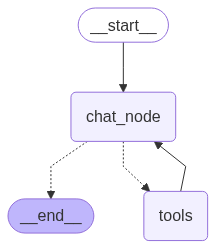

In [9]:
chatbot = graph.compile()
chatbot

In [16]:
out = chatbot.invoke({'messages': [HumanMessage(content="Fetch me links for new Machine Lerarning Jobs for freshers in India")]})
print(out['messages'][-1].content)

Here are some links for new Machine Learning Jobs for freshers in India:

* https://www.naukri.com/fresher-machine-learning-jobs
* https://internshala.com/jobs-machine-learning
* https://www.glassdoor.co.in/Jobs/fresher-machine-learning-jobs-SRCH_IL.0,14.htm
* https://www.linkedin.com/jobs/fresher-machine-learning-jobs
* https://www.indeed.co.in/Fresher-Machine-Learning-jobs

You can also check out the following companies that are hiring for Machine Learning roles in India:

* Cognic Systems Pvt Ltd
* SkillSpark
* Silent Infotech
* Arrk Group
* App Innovation

Some popular job roles for freshers in Machine Learning include:

* Machine Learning Engineer (Intern/Junior)
* AI Research Assistant
* Data Analyst with ML Tools
* Junior Data Scientist
* AI Software Developer
* Natural Language Processing Engineer

Remember to tailor your resume and cover letter to the specific job you're applying for, and practice your coding skills to increase your chances of getting hired. Good luck!
